### Generate Statistics:

**Daily average traveled distance (scaled by user)**

We will also look at the daily average traveled distance.


**Daily movement entropy**

Calculate movement entropy and its temporal variation in a year span.


**Daily count of check-ins (scaled by user)**

We will number the check-ins during a day in a year span.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # needed for plotting
import geopandas as gpd # for Geo-location filtering
from netCDF4 import Dataset as nc  # for loading standard climate date format (nc extension)
import netCDF4 # for loading standard climate date format (nc extension)
import xarray as xr # for handling climate data
from pandarallel import pandarallel # for running pandas functions in parallel
import multiprocessing # for general parallelizing of codes
from tqdm import tqdm # for having progres bar
from functools import partial # for full control over handling function arguemnts
pandarallel.initialize(nb_workers=multiprocessing.cpu_count()-1)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [52]:
from datetime import datetime, date
from scipy import stats
import holidays
tqdm.pandas()

In [53]:
PATH_GOWALLA = 'data/home_and_checkin_with_states_gowalla.csv'
PATH_BRIGHT = 'data/home_and_checkin_with_states_bright.csv'
df_gowalla = pd.read_csv(PATH_GOWALLA)
df_bright = pd.read_csv(PATH_BRIGHT)

In [54]:
PATH_GOWALLA2 = 'data/cck_in_USA_user_g.csv'
PATH_BRIGHT2 = 'data/cck_in_USA_user_b.csv'
df_gowalla2 = pd.read_csv(PATH_GOWALLA2)
df_bright2 = pd.read_csv(PATH_BRIGHT2)

In [55]:
df_gowalla = df_gowalla.drop(['Unnamed: 0'], axis=1)
df_bright = df_bright.drop(['Unnamed: 0'], axis=1)
df_gowalla2 = df_gowalla2.drop(['Unnamed: 0'], axis=1)
df_bright2 = df_bright2.drop(['Unnamed: 0'], axis=1)

In [63]:
len(df_bright2['user'].unique())

29881

In [64]:
len(df_bright['user'].unique())

13354

In [58]:
len(df_gowalla2['user'].unique())

49605

In [59]:
len(df_gowalla['user'].unique())

49605

## Holidays

In [6]:
df_gowalla['date'] = pd.to_datetime(df_gowalla['date'], format = '%Y-%m-%d')
df_bright['date'] = pd.to_datetime(df_bright['date'], format = '%Y-%m-%d')

KeyError: 'date'

In [ ]:
df_gowalla['us_holiday'] = df_gowalla['date'].progress_apply(us_holidays.get)

In [7]:
df_bright['us_holiday'] = df_bright['date'].progress_apply(us_holidays.get)

KeyError: 'date'

In [382]:
df_gowalla['date'].max()

Timestamp('2010-10-23 00:00:00')

## Seasons:

Northern Hemisphere for local time of Denver, CO.
https://www.calendardate.com/year2009.php

In [383]:
def seasons(date):
    
    spring_2008 = datetime.strptime('2008-03-19', '%Y-%m-%d')
    summer_2008 = datetime.strptime('2008-06-20', '%Y-%m-%d')
    autumn_2008 = datetime.strptime('2008-09-22', '%Y-%m-%d')
    winter_2008 = datetime.strptime('2008-12-21', '%Y-%m-%d')
    spring_2009 = datetime.strptime('2009-03-20', '%Y-%m-%d')
    summer_2009 = datetime.strptime('2009-06-20', '%Y-%m-%d')
    autumn_2009 = datetime.strptime('2009-09-22', '%Y-%m-%d')
    winter_2009 = datetime.strptime('2009-12-21', '%Y-%m-%d')
    spring_2010 = datetime.strptime('2010-03-20', '%Y-%m-%d')
    summer_2010 = datetime.strptime('2010-06-21', '%Y-%m-%d')
    autumn_2010 = datetime.strptime('2010-09-22', '%Y-%m-%d')
    winter_2010 = datetime.strptime('2010-12-21', '%Y-%m-%d')
    
    if spring_2008 >= date:
        return 'winter_2007'
    elif summer_2008 >= date:
        return 'spring_2008'
    elif autumn_2008 >= date:
        return 'summer_2008'
    elif winter_2008 >= date:
        return 'autumn_2008'
    elif spring_2009 >= date:
        return 'winter_2008'
    elif summer_2009 >= date:
        return 'spring_2009'
    elif autumn_2009 >= date:
        return 'summer_2009'
    elif winter_2009 >= date:
        return 'autumn_2009'
    elif spring_2010 >= date:
        return 'winter_2010'
    elif summer_2010 >= date:
        return 'spring_2010'
    elif autumn_2010 >= date:
        return 'summer_2010' 
    elif winter_2010 >= date:
        return 'autumn_2010'
    else:
        return np.nan

In [348]:
#Check that this is working correctly!!!
df_gowalla['season'] = df_gowalla['date'].progress_apply(seasons)

100%|██████████| 3484212/3484212 [03:42<00:00, 15627.33it/s]


In [343]:
df_bright['season'] = df_bright['date'].progress_apply(seasons)

100%|██████████| 1491726/1491726 [01:29<00:00, 16587.26it/s]


In [350]:
df_gowalla['season'].value_counts()

autumn_2010    1272736
summer_2010     943382
spring_2010     646639
winter_2009     170361
autumn_2009       5483
summer_2009       2158
spring_2009        668
Name: season, dtype: int64

In [351]:
df_bright['season'].value_counts()

winter_2008    454114
spring_2009    237521
summer_2009    230366
autumn_2009    224550
winter_2009    118887
spring_2010     80857
autumn_2010     66104
summer_2010     58073
Name: season, dtype: int64

In [404]:
df_gowalla.to_csv('./data/temp_seasons_gowalla.csv', index=False)
df_bright.to_csv('./data/temp_seasons_bright.csv', index=False)

In [508]:
df_gowalla = pd.read_csv('./data/temp_seasons_gowalla.csv')
df_bright = pd.read_csv('./data/temp_seasons_bright.csv')

## Distance From Home

In [586]:
def dist_km(Lat_start,Long_start,Lat_end,Long_end):
    '''
    Input : latitude and longitude of a point A and B
    Output : Distance between A and B
    
    '''
    if (Lat_start!=Lat_start) or (Long_start!=Long_start) or (Lat_end!=Lat_end) or (Long_end!=Long_end):
        return np.nan
    
    # Calcul with the method of sinus
    distance_km = np.arccos(np.sin(np.pi * Lat_start / 180.0) * np.sin(np.pi * Lat_end / 180.0) \
                          + np.cos(np.pi * Lat_start / 180.0) * np.cos(np.pi * Lat_end / 180.0) \
                            * np.cos(np.pi * Long_start / 180.0 - np.pi * Long_end / 180.0)) * 6371
    return distance_km

In [585]:
df_gowalla['distance_from_home'] = df_gowalla.progress_apply(lambda x: dist_km(x['user_house_lat'],\
                                                                     x['user_house_long'],\
                                                                     x['latitude'],\
                                                                     x['longitude']), axis=1)

  8%|▊         | 268022/3484212 [00:08<01:16, 41887.78it/s]<ipython-input-584-2d62ac8ea4ab>:11: RuntimeWarning: invalid value encountered in arccos
  distance_km = np.arccos(np.sin(np.pi * Lat_start / 180.0) * np.sin(np.pi * Lat_end / 180.0) \
 31%|███       | 1080101/3484212 [00:28<01:03, 38107.72it/s]


KeyboardInterrupt: 

In [513]:
df_bright['distance_from_home'] = df_bright.progress_apply(lambda x: dist_km(x['user_house_lat'],\
                                                                     x['user_house_long'],\
                                                                     x['latitude'],\
                                                                     x['longitude']), axis=1)

100%|██████████| 1491726/1491726 [00:38<00:00, 38747.91it/s]


## Distance between user check-ins

**Daily average distance. **
- going to join the table again but with the prevous check in so I have current check in and previous check in. Can then calculate the distance between and sum those distances by day.
- assumption is people are checking in all the time

In [565]:
def offset(data):
    data_reset = data.reset_index(drop=True)
    data_offset = data_reset.set_index(np.arange(1, data_reset.shape[0]+1, 1))[['latitude','longitude']]
    return data_reset.merge(data_offset, how='left',left_index=True, right_index=True,\
                            suffixes=['','_prev_check'])

In [566]:
df_gowalla_off = df_gowalla.sort_values('time_obj', ascending=True).groupby('user')\
                                                    .progress_apply(lambda group: offset(group))

100%|██████████| 49605/49605 [02:55<00:00, 282.64it/s]


In [567]:
df_bright_off = df_bright.sort_values('time_obj', ascending=True).groupby('user')\
                                                    .progress_apply(lambda group: offset(group))

100%|██████████| 13354/13354 [00:45<00:00, 294.36it/s]


In [569]:
df_gowalla_off = df_gowalla_off.reset_index(drop=True)
df_bright_off = df_bright_off.reset_index(drop=True)

In [587]:
df_gowalla_off['distance_from_prev_check'] = df_gowalla_off.progress_apply(lambda x: dist_km(x['latitude'],\
                                                                     x['longitude'],\
                                                                     x['latitude_prev_check'],\
                                                                     x['longitude_prev_check']), axis=1)

  0%|          | 1/3484212 [00:02<2740:17:56,  2.83s/it]<ipython-input-586-2d62ac8ea4ab>:11: RuntimeWarning: invalid value encountered in arccos
  distance_km = np.arccos(np.sin(np.pi * Lat_start / 180.0) * np.sin(np.pi * Lat_end / 180.0) \
100%|██████████| 3484212/3484212 [01:34<00:00, 36769.83it/s]


In [588]:
df_bright_off['distance_from_prev_check'] = df_bright_off.progress_apply(lambda x: dist_km(x['latitude'],\
                                                                     x['longitude'],\
                                                                     x['latitude_prev_check'],\
                                                                     x['longitude_prev_check']), axis=1)

  0%|          | 1/1491726 [00:01<511:18:26,  1.23s/it]<ipython-input-586-2d62ac8ea4ab>:11: RuntimeWarning: invalid value encountered in arccos
  distance_km = np.arccos(np.sin(np.pi * Lat_start / 180.0) * np.sin(np.pi * Lat_end / 180.0) \
100%|██████████| 1491726/1491726 [00:39<00:00, 38016.96it/s]


This next section is for features that we are going to calculate over a certain period of time. We will have things like:
- Entropy per hour
- Average check ins per hour
- Average distance from home per hour
- 

In [591]:
df_gowalla_off.to_csv('./data/seasons_distances_gowalla.csv', index=False)
df_bright_off.to_csv('./data/seasons_distances_bright.csv', index=False)

In [3]:
df_gowalla = pd.read_csv('./data/seasons_distances_gowalla.csv')
df_bright = pd.read_csv('./data/seasons_distances_bright.csv')

## Add Timezones & Local Time

In [37]:
from timezonefinder import TimezoneFinderL
tf = TimezoneFinderL(in_memory=False)

In [54]:
from pytz import timezone
import pytz
utc = pytz.utc

In [312]:
df_bright = pd.read_csv('data/bright_totalClean.csv')

In [313]:
#Z stands for GMT and UTC timezone it is offset from 0 by coordinated time

df_gowalla['time_obj'] = pd.to_datetime(df_gowalla['checkin_time'].str.replace('[T]',':').str.replace('Z',''),\
                                        format='%Y-%m-%d:%H:%M:%S')

df_bright['time_obj'] = pd.to_datetime(df_bright['checkin_time'].str.replace('[T]',':').str.replace('Z',''),\
                                        format='%Y-%m-%d:%H:%M:%S')

In [314]:
df_bright['timezone'] = df_bright[['longitude', 'latitude']].progress_apply(lambda x:tf.timezone_at(lng=x[0],lat=x[1]),axis=1)

100%|██████████| 4492552/4492552 [00:55<00:00, 81263.12it/s]


In [41]:
df_gowalla['timezone'] = df_gowalla[['longitude', 'latitude']].progress_apply(lambda x:tf.timezone_at(lng=x[0],lat=x[1]),axis=1)

100%|██████████| 3484212/3484212 [00:41<00:00, 84014.05it/s]


In [106]:
df_gowalla['utc'] = df_gowalla['time_obj'].progress_apply(timezone(utc.zone).localize)

100%|██████████| 3484212/3484212 [00:29<00:00, 117068.22it/s]


In [315]:
df_bright['utc'] = df_bright['time_obj'].progress_apply(timezone(utc.zone).localize)

100%|██████████| 4492552/4492552 [00:38<00:00, 115944.11it/s]


In [107]:
df_gowalla['local_time'] = df_gowalla[['utc','timezone']].progress_apply(lambda x: x[0].astimezone(timezone(x[1])),axis=1)

100%|██████████| 3484212/3484212 [01:16<00:00, 45302.08it/s]


In [336]:
df_bright['local_time'] = df_bright[['utc','timezone']].progress_apply(lambda x: x[0].astimezone(timezone(x[1])),axis=1)

100%|██████████| 4490243/4490243 [01:47<00:00, 41598.14it/s]


In [108]:
df_gowalla['local_time_grouper'] = df_gowalla['local_time'].progress_apply(lambda x: x.replace(tzinfo=None))

100%|██████████| 3484212/3484212 [00:32<00:00, 107001.20it/s]


In [337]:
df_bright['local_time_grouper'] = df_bright['local_time'].progress_apply(lambda x: x.replace(tzinfo=None))

100%|██████████| 4490243/4490243 [00:46<00:00, 97237.56it/s] 


In [129]:
df_gowalla = df_gowalla.assign(
        unique_loc=[str(x) + str(y) for x, y in zip(df_gowalla['latitude'], df_gowalla['longitude'])])

In [338]:
df_bright = df_bright.assign(
        unique_loc=[str(x) + str(y) for x, y in zip(df_bright['latitude'], df_bright['longitude'])])

In [311]:
df_gowalla.to_csv('./data/seasons_distances_timezone_gowalla.csv', index=False)
df_bright.to_csv('./data/seasons_distances_timezone_bright.csv', index=False)

In [ ]:
df_gowalla = pd.read_csv('./data/seasons_distances_timezone_gowalla.csv')
df_bright = pd.read_csv('./data/seasons_distances_timezone_bright.csv')

## Entropy

**Daily Movement Entropy (Average entropy of check in locations over time)**
- average shannon entropy of check in locations for each hour of the week
- lower the entropy, lower the variability of check ins during that time period
- need to recreate the graphs to make sure using correct shannon entropy

H(X) = -$\sum_{i=1}^{n} P(x_i)LogP(x_i)$

Took inspiration from this stack overflow for entropy
https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

In [164]:
def apply_entropy(data):
    p_data = data.value_counts()
    ent = stats.entropy(p_data, base=2)
    return ent

In [339]:
df_gowalla_group = df_gowalla.groupby(pd.Grouper(key="local_time_grouper", freq="1H"))
df_bright_group = df_bright.groupby(pd.Grouper(key="local_time_grouper", freq="1H"))

In [166]:
# df_bright_group['unique_loc'].progress_apply(apply_entropy)

In [167]:
apply_entropy(df_bright_group.get_group('2008-09-17 20:00:00')['unique_loc'])

6.281209564709819

In [168]:
df_bright_group.get_group('2008-09-18 4:00:00')['unique_loc'].value_counts()

42.739496-78.845522            1
29.424122-98.493628            1
37.777855-122.423192           1
42.205883-72.604663            1
34.754052-77.43024100000002    1
Name: unique_loc, dtype: int64

In [340]:
entropy_hour_gowalla = df_gowalla_group['unique_loc'].progress_apply(apply_entropy)
entropy_hour_gowalla = entropy_hour_gowalla.to_frame().reset_index(drop=False)

entropy_hour_bright = df_bright_group['unique_loc'].progress_apply(apply_entropy)
entropy_hour_bright = entropy_hour_bright.to_frame().reset_index(drop=False)

100%|██████████| 22597/22597 [00:17<00:00, 1315.29it/s]


<AxesSubplot:xlabel='local_time_grouper'>

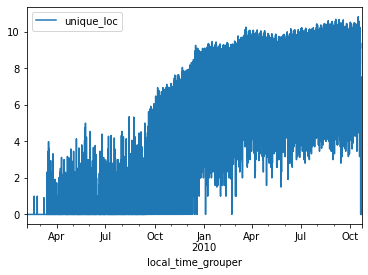

In [170]:
entropy_hour_gowalla.plot(x = 'local_time_grouper', y='unique_loc')

In [171]:
#entropy_hour = entropy_hour[(entropy_hour.time_obj >= pd.Timestamp(year=2009,month=1,day=1))\
#                            &(entropy_hour.time_obj < pd.Timestamp(year=2010,month=1,day=1))].copy()

In [172]:
entropy_hour_gowalla['weekday'] = entropy_hour_gowalla['local_time_grouper'].map(lambda x: x.weekday())
entropy_hour_gowalla['hour'] = entropy_hour_gowalla['local_time_grouper'].map(lambda x: x.hour)

In [341]:
entropy_hour_bright['weekday'] = entropy_hour_bright['local_time_grouper'].map(lambda x: x.weekday())
entropy_hour_bright['hour'] = entropy_hour_bright['local_time_grouper'].map(lambda x: x.hour)

In [174]:
entropy_hour_gowalla.head()

,local_time_grouper,unique_loc,weekday,hour
0,2009-02-03 23:00:00,0.0,1,23
1,2009-02-04 00:00:00,0.0,2,0
2,2009-02-04 01:00:00,0.0,2,1
3,2009-02-04 02:00:00,0.0,2,2
4,2009-02-04 03:00:00,0.0,2,3


In [175]:
#entropy_hour = entropy_hour[entropy_hour['unique_loc'] != 0]

In [176]:
entropy_hour_gowalla.groupby(['weekday','hour']).get_group((4,10)).mean()

<ipython-input-176-f47f27afc1ed>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  entropy_hour_gowalla.groupby(['weekday','hour']).get_group((4,10)).mean()


unique_loc     5.285425
weekday        4.000000
hour          10.000000
dtype: float64

In [177]:
entropy_week_hour_gowalla = entropy_hour_gowalla.groupby(['weekday','hour']).mean()
entropy_week_hour_gowalla = entropy_week_hour_gowalla.reset_index(drop=False)

In [342]:
entropy_week_hour_bright = entropy_hour_bright.groupby(['weekday','hour']).mean()
entropy_week_hour_bright = entropy_week_hour_bright.reset_index(drop=False)

In [179]:
entropy_week_hour_gowalla['graph_date'] = entropy_week_hour_gowalla.apply(lambda x: \
                                                          pd.Timestamp(year=2020,month=6,day=int(x['weekday']+1),\
                                                                       hour=int(x['hour'])),axis=1)

In [343]:
entropy_week_hour_bright['graph_date'] = entropy_week_hour_bright.apply(lambda x: \
                                                          pd.Timestamp(year=2020,month=6,day=int(x['weekday']+1),\
                                                                       hour=int(x['hour'])),axis=1)

In [181]:
entropy_week_hour_gowalla

,weekday,hour,unique_loc,graph_date
0,0,0,3.601481,2020-06-01 00:00:00
1,0,1,2.865031,2020-06-01 01:00:00
2,0,2,2.402634,2020-06-01 02:00:00
3,0,3,1.773398,2020-06-01 03:00:00
4,0,4,2.088523,2020-06-01 04:00:00
...,...,...,...,...
163,6,19,5.655092,2020-06-07 19:00:00
164,6,20,5.300824,2020-06-07 20:00:00
165,6,21,4.953262,2020-06-07 21:00:00
166,6,22,4.476978,2020-06-07 22:00:00


In [182]:
entropy_week_hour_bright

,weekday,hour,unique_loc,graph_date
0,0,0,4.378599,2020-06-01 00:00:00
1,0,1,3.806590,2020-06-01 01:00:00
2,0,2,3.020734,2020-06-01 02:00:00
3,0,3,2.411321,2020-06-01 03:00:00
4,0,4,2.131414,2020-06-01 04:00:00
...,...,...,...,...
163,6,19,5.631946,2020-06-07 19:00:00
164,6,20,5.515212,2020-06-07 20:00:00
165,6,21,5.333050,2020-06-07 21:00:00
166,6,22,5.110335,2020-06-07 22:00:00


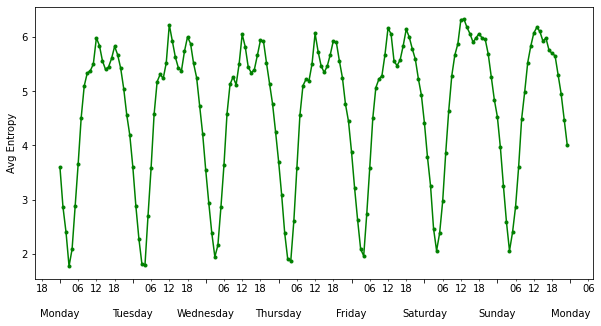

In [183]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set(xlabel='', ylabel='Avg Entropy')
ax1.plot(entropy_week_hour_gowalla.graph_date, entropy_week_hour_gowalla['unique_loc'], color='g', marker = '.')
#ax1.plot(entropy_week_hour.graph_date, entropy_week_hour['unique_loc'], color='g', marker = '.')
#ax1.plot(entropy_hour.index, df_bright.Registered, color='b')

ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%A"),
    minor_locator=mdates.HourLocator((6 ,12, 18)),
    minor_formatter=mdates.DateFormatter("%H"),
)
plt.show()

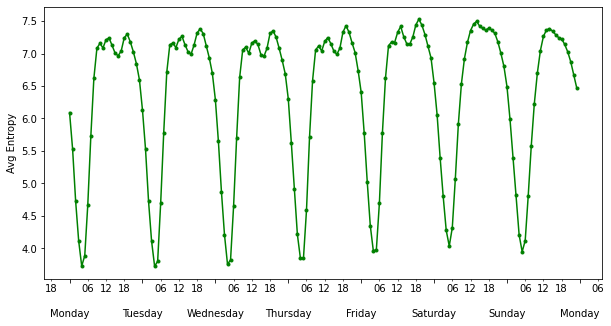

In [344]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set(xlabel='', ylabel='Avg Entropy')
ax1.plot(entropy_week_hour_bright.graph_date, entropy_week_hour_bright['unique_loc'], color='g', marker = '.')
#ax1.plot(entropy_week_hour.graph_date, entropy_week_hour['unique_loc'], color='g', marker = '.')
#ax1.plot(entropy_hour.index, df_bright.Registered, color='b')

ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%A"),
    minor_locator=mdates.HourLocator((6 ,12, 18)),
    minor_formatter=mdates.DateFormatter("%H"),
)
plt.show()

## Trial 2

Maybe I need a certain threshold of time that someone has been active? If they just started and we only have data over a month or two it is likely their entropy will be very low as they may just have 1 or two places per week...

In [345]:
df_bright2 = df_bright.copy()

In [346]:
df_bright2['weekday'] = df_bright2['local_time_grouper'].map(lambda x: x.weekday())
df_bright2['hour'] = df_bright2['local_time_grouper'].map(lambda x: x.hour)

In [347]:
df_bright2_group = df_bright2.groupby(['user','weekday','hour'])
#df_bright_group = df_bright.groupby(pd.Grouper(key="local_time_grouper", freq="1H"))

In [348]:
entropy_bright2 = df_bright2_group['unique_loc'].progress_apply(apply_entropy)
entropy_bright2 = entropy_bright2.to_frame().reset_index(drop=False)

100%|██████████| 1287125/1287125 [11:43<00:00, 1828.47it/s]


In [355]:
entropy_bright2 = entropy_bright2[entropy_bright2['unique_loc'] > 0]

<AxesSubplot:>

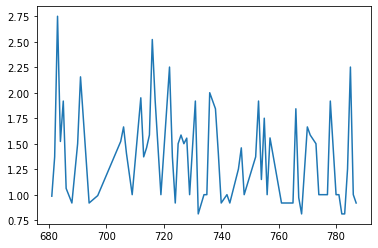

In [356]:
entropy_bright2[entropy_bright2['user']==5]['unique_loc'].plot()

In [357]:
entropy_mean_bright2 = entropy_bright2.drop('user', axis=1).groupby(['weekday','hour']).mean().reset_index(drop=False)

In [358]:
entropy_mean_bright2['graph_date'] = entropy_mean_bright2.apply(lambda x: \
                                                          pd.Timestamp(year=2020,month=6,day=int(x['weekday']+1),\
                                                                       hour=int(x['hour'])),axis=1)

In [359]:
entropy_mean_bright2

,weekday,hour,unique_loc,graph_date
0,0,0,1.263140,2020-06-01 00:00:00
1,0,1,1.224780,2020-06-01 01:00:00
2,0,2,1.173467,2020-06-01 02:00:00
3,0,3,1.159356,2020-06-01 03:00:00
4,0,4,1.154171,2020-06-01 04:00:00
...,...,...,...,...
163,6,19,1.567093,2020-06-07 19:00:00
164,6,20,1.513274,2020-06-07 20:00:00
165,6,21,1.455613,2020-06-07 21:00:00
166,6,22,1.384949,2020-06-07 22:00:00


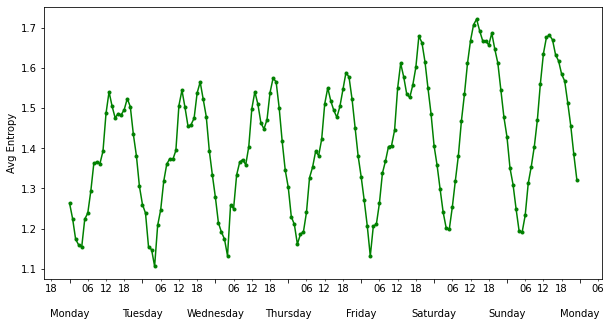

In [360]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set(xlabel='', ylabel='Avg Entropy')
ax1.plot(entropy_mean_bright2.graph_date, entropy_mean_bright2['unique_loc'], color='g', marker = '.')
#ax1.plot(entropy_week_hour.graph_date, entropy_week_hour['unique_loc'], color='g', marker = '.')
#ax1.plot(entropy_hour.index, df_bright.Registered, color='b')

ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%A"),
    minor_locator=mdates.HourLocator((6 ,12, 18)),
    minor_formatter=mdates.DateFormatter("%H"),
)
plt.show()

## Trial 3

In [240]:
df_bright3 = df_bright.copy()

In [241]:
df_bright3['weekday'] = df_bright3['local_time_grouper'].map(lambda x: x.weekday())
df_bright3['hour'] = df_bright3['local_time_grouper'].map(lambda x: x.hour)

df_bright3_group = df_bright3.groupby(['unique_loc','weekday','hour'])

In [260]:
for name, data in df_bright3_group:
    print(name)
    break

('13.444304144.793731', 4, 3)


In [249]:
entropy_bright3 = df_bright3_group['user'].progress_apply(apply_entropy)
entropy_bright3 = entropy_bright3.to_frame().reset_index(drop=False)

100%|██████████| 758806/758806 [05:27<00:00, 2316.12it/s]


In [255]:
#entropy_bright3 = entropy_bright3[entropy_bright3['user'] > 0]

In [256]:
entropy_bright3.head()

,unique_loc,weekday,hour,user
465,18.248288-66.499894,2,12,1.000000
1047,18.36938-66.05388,0,12,1.000000
1130,18.380782-65.957387,3,11,0.918296
1421,18.418091-65.96893399999999,2,22,1.000000
1825,18.466334-66.105722,3,11,1.000000


In [257]:
entropy_mean_bright3 = entropy_bright3.drop('unique_loc', axis=1).groupby(['weekday','hour']).mean().reset_index(drop=False)

In [258]:
entropy_mean_bright3['graph_date'] = entropy_mean_bright3.apply(lambda x: \
                                                          pd.Timestamp(year=2020,month=6,day=int(x['weekday']+1),\
                                                                       hour=int(x['hour'])),axis=1)

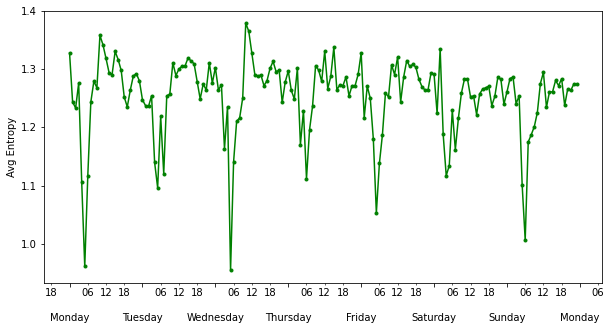

In [259]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set(xlabel='', ylabel='Avg Entropy')
ax1.plot(entropy_mean_bright3.graph_date, entropy_mean_bright3['user'], color='g', marker = '.')
#ax1.plot(entropy_week_hour.graph_date, entropy_week_hour['unique_loc'], color='g', marker = '.')
#ax1.plot(entropy_hour.index, df_bright.Registered, color='b')

ax1.xaxis.set(
    major_locator=mdates.DayLocator(),
    major_formatter=mdates.DateFormatter("\n\n%A"),
    minor_locator=mdates.HourLocator((6 ,12, 18)),
    minor_formatter=mdates.DateFormatter("%H"),
)
plt.show()